In [34]:
%reset
import numpy as np
from osgeo import gdal, osr, ogr
from skimage import exposure
from skimage.segmentation import quickshift, slic
from sklearn.ensemble import RandomForestClassifier
import time
import os
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pickle
from sklearn.linear_model import LogisticRegression

## based on tutorial from https://opensourceoptions.com/blog/python-geographic-object-based-image-analysis-geobia/


naip_fn = "D:/cbr/VP2/VP2_SoilMapping/CodeOutput/output_file_channelFusion_2.tif"
load_model = pickle.load(open('classifier_prediction_model.sav', "rb"))

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)

nbands = naip_ds.RasterCount
band_data = []

print('bands', naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)
for i in range(1, nbands+1):
        band = naip_ds.GetRasterBand(i).ReadAsArray()
        band_data.append(band)

band_data = np.dstack(band_data)

bands 6 rows 5808 columns 6668


In [35]:
# scale image values from 0.0 - 1.0
#band_data[np.isnan(band_data)] = 0
band_data[np.isnan(band_data)] = -9999.0
img = exposure.rescale_intensity(band_data, in_range= (0.0, 225))

# do segmentation multiple options with quickshift and slic
seg_start = time.time()
# segments = quickshift(img, ratio=0.99, max_dist=5, convert2lab=False)
segments = slic(img, n_segments=1000, compactness=3, start_label = 1)
print('segments complete', time.time() - seg_start)

def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            band_stats[3] = 0.0
        features += band_stats
    return features

segments complete 77.96110129356384


In [36]:
segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

In [37]:
predicted = load_model.predict(objects)

clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass

print('Prediction applied to numpy array')

mask = np.sum(img, axis=2)
mask[mask> 0] = 1.0
mask[mask == 0] = -1.0

clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

print('Saving classification to raster')
def CreateGeoTiff(Name, Array, driver, GeoT, Projection, DataType):
    DataSet = driver.Create(Name, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection)
    DataSet.GetRasterBand(1).SetNoDataValue(-9999.0)
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet.FlushCache()
    return Name

CreateGeoTiff('D:/cbr/VP2/VP2_SoilMapping/Processed/prediction_Punkte.tif', clf, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)
print('Done')

Prediction applied to numpy array
Saving classification to raster
Done


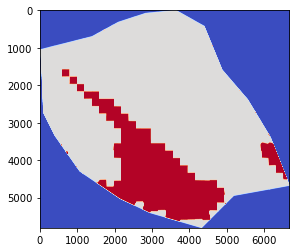

In [42]:
import matplotlib as mp
import matplotlib.pyplot as plt

img=plt.imread('D:/cbr/VP2/VP2_SoilMapping/Processed/prediction_Punkte.tif')
imgplot = plt.imshow(img[:, :, 0], cmap=plt.cm.coolwarm)
